In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

def run(i):
    
    # parameter to seperate template area from find temple area
    cropcol = 60
    
    path2files = '/home/junyi/R/RPA/yolo/c3/'
    target_rgb_raw = cv2.imread(path2files + '验证码_{:03d}.png'.format(i))
    target_rgb = target_rgb_raw[:,:cropcol,:]
    template_gray = cv2.imread(path2files + 'slider_{:03d}.png'.format(i), 0)

    
    # PART1 - find y area where figures are located, in order to crop out unnecessary parts
    
    # target: find green area with mask filter
    hsv = cv2.cvtColor(target_rgb, cv2.COLOR_BGR2HSV)
    lower_green = np.array([50,60,60])
    upper_green = np.array([90,255,255])
    mask = cv2.inRange(hsv, lower_green, upper_green)
    
    # target: do erode+dilate in order to delete noise
    
    # first try erode+dilate on 3x3
    kernel = np.ones((3,3),np.uint8)
    maskm = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    # if first fail, second try erode+dilate on 1x1
    if np.min(np.where(maskm.sum(1)>0))>=118 : 
        kernel = np.ones((1,1),np.uint8)
        maskm = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    # if second fail, do not run any erode+dilate
    if np.min(np.where(maskm.sum(1)>0))>=118 : 
        maskm = mask



    # define y area where figures are located
    index_step = 10
    top_index = np.min(np.where(maskm.sum(1)>0)) - index_step
    bot_index = top_index + index_step + index_step + 40 



    # PART2 - clean template 
    
    ret, template_threshed = cv2.threshold(template_gray, 70, 250, cv2.THRESH_BINARY)
    contour,hier = cv2.findContours(template_threshed,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contour:
        cv2.drawContours(template_threshed,[cnt],0,255,-1)
    template_gray0 = template_gray*(template_threshed/255).astype(np.uint8)
    xvals  = np.where(template_gray0.any(axis=0))
    xvals1 = max(0,np.min(xvals)-5)
    xvals2 = np.max(xvals)+5
    yvals  = np.where(template_gray0.any(axis=1))
    yvals1 = max(0,np.min(yvals)-5)
    yvals2 = np.max(yvals)+5
    template_gray01 = template_gray0[yvals1:yvals2,xvals1:xvals2]

    template_gray2 = np.delete (template_gray01, np.where(~template_gray01.any(axis=1)), axis=0)
    template_gray2 = np.delete (template_gray2, np.where(~template_gray2.any(axis=0)), axis=1)
    template_gray2 =  cv2.resize(template_gray2, (40,40)).astype(np.uint8)
    template_gray1 = template_gray2.copy()
    template_gray2[template_gray2>0]=255
    w, h = template_gray2.shape[::-1]
    edges = cv2.Canny(template_gray2,50,150,apertureSize = 3)

    template_gray01[template_gray01>0]=255
    edges1 = cv2.Canny(template_gray01,50,150,apertureSize = 3)
    edges1 = np.delete (edges1, np.where(~edges1.any(axis=1)), axis=0)
    edges1 = np.delete (edges1, np.where(~edges1.any(axis=0)), axis=1)
    edges1 =  cv2.resize(edges1, (40,40)).astype(np.uint8)
    edges1[edges1>0] = 255


    # PART3 - clean crop out target
    
    # crop out unnecessary parts and apply threshold functions
    target_rgb = target_rgb_raw[top_index:bot_index,cropcol:,:]
    target_gray = cv2.cvtColor(target_rgb, cv2.COLOR_BGR2GRAY)
    ret, threshed0 = cv2.threshold(target_gray, 50, 255, cv2.THRESH_TOZERO)
    ret, threshed0 = cv2.threshold(threshed0, 55, 60, cv2.THRESH_TOZERO)
    thresh = cv2.adaptiveThreshold(threshed0, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 6)


    # PART4 - match target contours with template contours
    df = pd.DataFrame()
    
    # run 4 models 
    res1 = cv2.matchTemplate(thresh, edges, cv2.TM_CCOEFF)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res1)
    df = df.append(pd.Series([min_val]+list(min_loc)), ignore_index=True)
    df = df.append(pd.Series([max_val]+list(max_loc)), ignore_index=True)

    res2 = cv2.matchTemplate(thresh, edges1, cv2.TM_CCOEFF)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res2)
    df = df.append(pd.Series([min_val]+list(min_loc)), ignore_index=True)
    df = df.append(pd.Series([max_val]+list(max_loc)), ignore_index=True)

    res2 = cv2.matchTemplate(threshed0, edges, cv2.TM_CCOEFF)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res2)
    df = df.append(pd.Series([min_val]+list(min_loc)), ignore_index=True)
    df = df.append(pd.Series([max_val]+list(max_loc)), ignore_index=True)

    res2 = cv2.matchTemplate(threshed0, edges1, cv2.TM_CCOEFF)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res2)
    df = df.append(pd.Series([min_val]+list(min_loc)), ignore_index=True)
    df = df.append(pd.Series([max_val]+list(max_loc)), ignore_index=True)


    # select top result based on correlation coef and topleft point location
    df.columns = ['coef','x','y']
    df['coef_abs'] = df.coef.abs()
    
    if (df.y>0).sum():
        df = df[df.y>0]
    if (df.y>7).sum():
        df = df[df.y>7]
    if (df.x>0).sum():
        df = df[df.x>0]
    if (df.y<18).sum():
        df = df[df.y<18]
    
    
    df = df.sort_values(by=['coef_abs'], ascending=False)
    top_left = (df.iloc[0,:].values[1:3])
    top_left = tuple(np.int16(top_left))
    distance = top_left[0]
    
    # plot debug
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(target_gray,top_left, bottom_right, 255, 2)
    x = [distance  +(w/2)]
    plt.subplot(211),plt.imshow(template_gray)
    plt.subplot(212),plt.imshow(target_gray),plt.plot(x, 30, '*', linewidth=5000, color='firebrick')
    plt.show() 
    print(df)
    
    return(distance+cropcol)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 3.58 µs


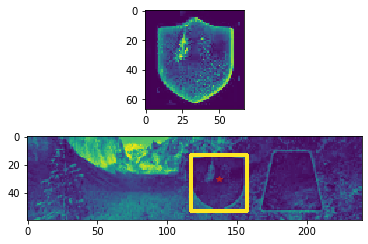

          coef      x     y     coef_abs
3  3709027.000  117.0  13.0  3709027.000
1  2449533.250  117.0  12.0  2449533.250
7  1895792.625  117.0  13.0  1895792.625
0 -1497647.500  173.0  10.0  1497647.500
5  1139140.000   47.0  17.0  1139140.000


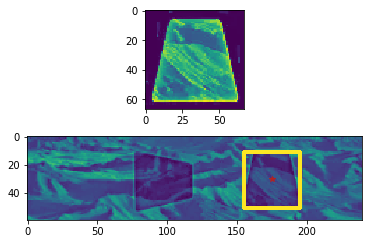

          coef      x     y     coef_abs
2 -5404147.000  155.0  11.0  5404147.000
3  4011067.000   85.0  12.0  4011067.000
0 -2205648.250  155.0  15.0  2205648.250
6 -1793313.625  155.0  11.0  1793313.625
4  -749322.500  155.0  15.0   749322.500


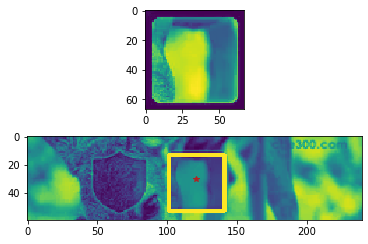

         coef      x     y    coef_abs
2 -4822295.00  101.0  13.0  4822295.00
3  3903287.75   46.0  14.0  3903287.75
6 -2411793.50  101.0  13.0  2411793.50
7  2160412.00   46.0  14.0  2160412.00


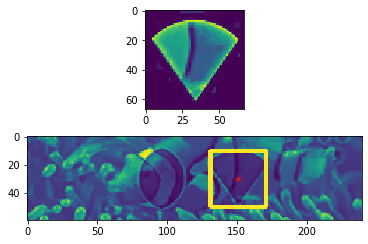

          coef      x     y     coef_abs
1  2405031.000  131.0  10.0  2405031.000
7  1449985.250  129.0   9.0  1449985.250
5  1278885.125  131.0  10.0  1278885.125


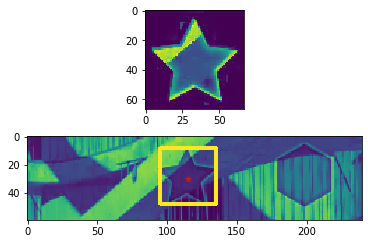

          coef      x     y     coef_abs
1  4184562.500   95.0   8.0  4184562.500
2 -3829159.250   67.0  10.0  3829159.250
3  3291078.250   95.0   8.0  3291078.250
6 -2540797.250   66.0  10.0  2540797.250
0 -2373208.750   65.0  12.0  2373208.750
5  1728441.500   95.0   8.0  1728441.500
4 -1496133.625   64.0  13.0  1496133.625
7  1469642.000  163.0  10.0  1469642.000


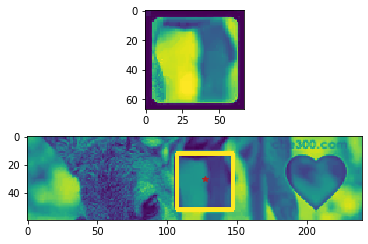

         coef      x     y    coef_abs
2 -5025538.00  107.0  12.0  5025538.00
6 -2096218.75   66.0  11.0  2096218.75
7  1977837.50  112.0  15.0  1977837.50


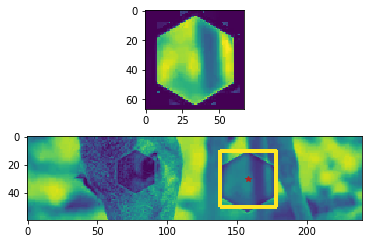

          coef      x     y     coef_abs
7  1868740.250  138.0  10.0  1868740.250
6 -1574639.625    1.0  17.0  1574639.625


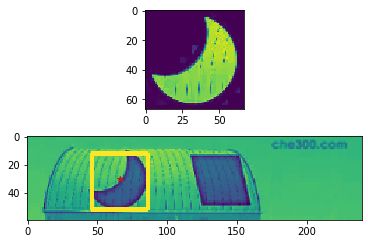

           coef      x     y      coef_abs
2 -3.760072e+06   46.0  12.0  3.760072e+06
3  2.448188e+06  119.0  14.0  2.448188e+06
6 -2.174949e+06   46.0  12.0  2.174949e+06
7  1.076075e+06  129.0  14.0  1.076075e+06
1  1.025606e+06  129.0  13.0  1.025606e+06
4 -6.268428e+05   47.0  13.0  6.268428e+05
5  3.389005e+05  130.0  16.0  3.389005e+05


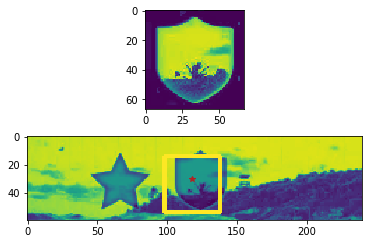

          coef      x     y     coef_abs
2 -3193540.750   98.0  14.0  3193540.750
0 -2046702.375  111.0  14.0  2046702.375
6 -1743173.125   67.0  13.0  1743173.125


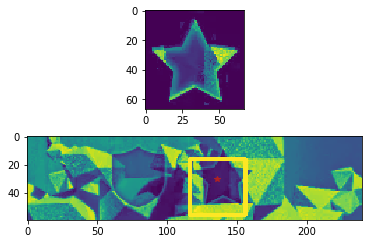

          coef      x     y     coef_abs
3  2454693.750  116.0  16.0  2454693.750
1  2086488.750  121.0  10.0  2086488.750
7  1742873.250  117.0  15.0  1742873.250
0 -1715685.125    1.0  15.0  1715685.125
6 -1621508.625  142.0  16.0  1621508.625
5  1102127.000  118.0  15.0  1102127.000
4  -916616.875  144.0  16.0   916616.875


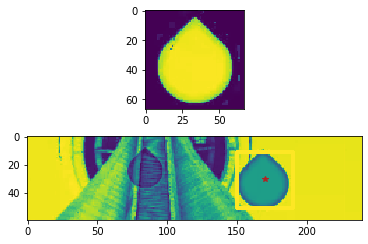

          coef      x     y     coef_abs
2 -2467129.750  150.0  11.0  2467129.750
0 -1566127.375  142.0  12.0  1566127.375
5  1255028.875  150.0  10.0  1255028.875
4  -830236.000   43.0  12.0   830236.000


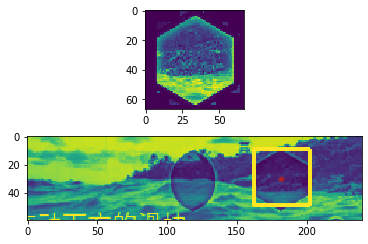

         coef      x    y    coef_abs
3  4206305.50  162.0  9.0  4206305.50
7  2555375.75  162.0  9.0  2555375.75


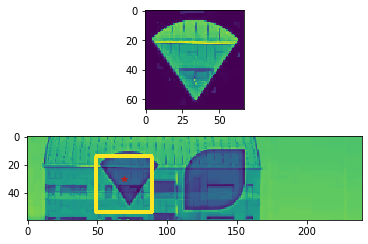

           coef      x     y      coef_abs
2 -3.802662e+06   49.0  14.0  3.802662e+06
0 -1.884872e+06  116.0  15.0  1.884872e+06
6 -9.595412e+05   53.0   8.0  9.595412e+05
5  7.755488e+05   53.0  11.0  7.755488e+05


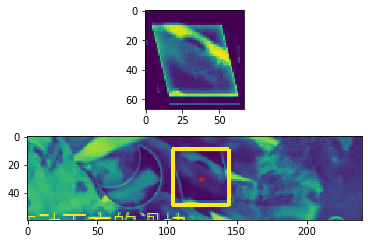

          coef      x     y     coef_abs
3  4244510.000  104.0   9.0  4244510.000
2 -3558085.750  160.0  11.0  3558085.750
0 -1718692.375  176.0  16.0  1718692.375
1  1643506.875   72.0  12.0  1643506.875
6 -1429802.750  129.0  16.0  1429802.750


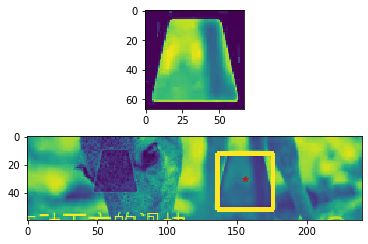

         coef      x     y    coef_abs
2 -6067972.00  136.0  12.0  6067972.00
3  4148108.25   45.0   9.0  4148108.25
7  2252680.25   45.0   9.0  2252680.25
6 -2225711.00  136.0  12.0  2225711.00
1  1950749.75   46.0  10.0  1950749.75


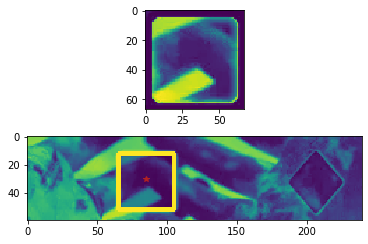

         coef     x     y    coef_abs
2 -2593116.00  65.0  12.0  2593116.00
7  2482393.75  63.0  10.0  2482393.75


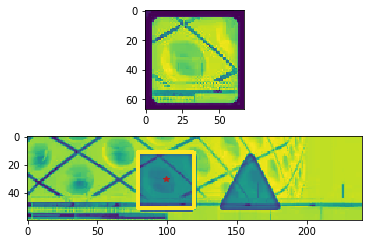

         coef      x     y    coef_abs
2 -5064391.50   79.0  11.0  5064391.50
3  2918566.75  143.0  14.0  2918566.75
6 -2205035.25   40.0  17.0  2205035.25
7  2155017.50  137.0  14.0  2155017.50


[177,
 215,
 161,
 191,
 155,
 167,
 198,
 106,
 158,
 176,
 210,
 222,
 109,
 164,
 196,
 125,
 139]

In [2]:
%time
cases = [0,2,4] + list(range(7,21))
mapres = list(map(run,cases))
mapres

In [6]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib import font_manager
import random

myfont = font_manager.FontProperties(fname='/usr/share/fonts/matplotlib_fonts/simhei.ttf')


In [19]:
def demo(i):
    
    # parameter to seperate template area from find temple area
    cropcol = 10
    
    path2files = '/home/machao/公共的/Python demo/'
    target_rgb_raw = cv2.imread(path2files + '验证码_{:03d}.png'.format(i))
    plt.subplot(231)
    plt.title('原图', fontproperties=myfont, fontsize=18)
    plt.imshow(target_rgb_raw)
      
    target_rgb = target_rgb_raw[:,cropcol:60,:]
    template_gray = cv2.imread(path2files + 'slider_{:03d}.png'.format(i), 0)

    
    # target: find green area with mask filter
    hsv = cv2.cvtColor(target_rgb, cv2.COLOR_BGR2HSV)
    plt.subplot(232)
    plt.title('HSV图', fontproperties=myfont, fontsize=18)
    plt.imshow(hsv)
    
    lower_green = np.array([50,60,60])
    upper_green = np.array([90,255,255])
    mask = cv2.inRange(hsv, lower_green, upper_green)
    plt.subplot(233)
    plt.title('mask图', fontproperties=myfont, fontsize=18)
    plt.imshow(mask)
    
        # first try erode+dilate on 3x3
    kernel = np.ones((3,3),np.uint8)
    maskm = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    plt.subplot(234)
    plt.title('maskm图', fontproperties=myfont, fontsize=18)
    plt.imshow(maskm)
    

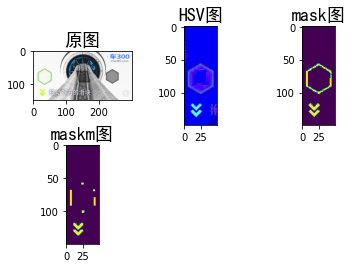

In [20]:
demo(6)

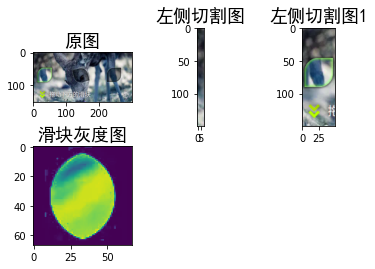

In [11]:
demo(3)

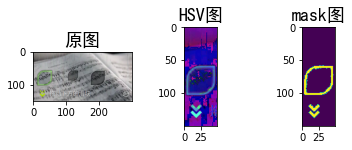

In [18]:
demo(4)

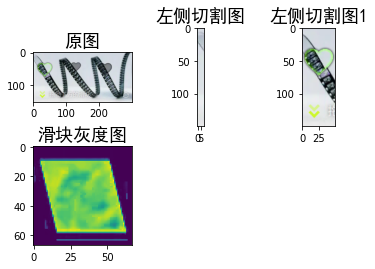

In [13]:
demo(5)